Primero, necesitamos instalar algunos paquetes, importar bibliotecas y utilitarios:

In [ ]:
!python -m spacy download es_core_news_md
!pip install pyLDAvis && python -m spacy download es_core_news_md
!pip install gensim

from pathlib import Path
from typing import List
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import es_core_news_md
import nltk
import chardet

nltk.download('stopwords')

In [ ]:
from IPython.display import display
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
#import pyLDAvis.gensim

#import es_core_news_sm
import os
import regex
# from spacy.lang.es.stop_words import STOP_WORDS
from string import punctuation
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
STOPWORDS = stopwords.words("spanish")

Luego montamos nuestro *Drive* donde se encuentra la carpeta DiscursosOriginales con los discursos presidenciales que serviran como base para el análisis:

In [ ]:
from google.colab import drive


# Montar disco desde google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ajustamos la  variable que especifica el directorio de documentos e inicializamos el método NLP (Natural Language Modeling).

In [ ]:
PATH = "/content/drive/MyDrive/DiscursosOriginales/"

nlp = es_core_news_md.load(disable=["paser", "ner"])


Re-utiizamos algunas funciones utilitarias vistas en clases que nos servirán para hacer la limpieza y el pre-procesamiento de los Discursos Presidenciales, las cuales definimos a continuación:




In [ ]:
def EliminaNumeroYPuntuacion(oracion):
    string_numeros = regex.sub(r'[\”\“\¿\°\d+]','', oracion)
    return ''.join(c for c in string_numeros if c not in punctuation)

def Lematizar(oracion):
   doc = nlp(oracion)
   lemas = [token.lemma_.lower() for token in doc]
   return(" ".join(lemas))  

def EliminarStopwords(oracion):
    Tokens = Tokenizar(oracion)
    oracion_filtrada = [word for word in Tokens if word not in STOPWORDS]
    return(" ".join(oracion_filtrada))

def Tokenizar(oracion):
    doc = nlp(oracion)
    tokens = [palabra.text for palabra in doc]
    return(tokens)

def Etiquetar(texto):
   doc = nlp(texto)
   Etiquetado = ''.join(t.text+"/"+t.pos_+" " for t in doc)
   return(Etiquetado.rstrip())

def CrearCorpus(path):
  directorio = os.listdir(path)
  corpus = []
  for filename  in directorio:
     texto = open(path+filename,'r',encoding="utf-8").read()
     texto = ConvertirAcentos(texto)
     corpus.append(texto)
  return(corpus)

def ConvertirAcentos(texto):
    texto=texto.replace("\xc3\xa1","á")
    texto=texto.replace("\xc3\xa9","é")   
    texto=texto.replace("\xc3\xad","í")
    texto=texto.replace("\xc3\xb3","ó")
    texto=texto.replace("\xc3\xba","ú")
    texto=texto.replace("\xc3\x81","Á")
    texto=texto.replace("\xc3\x89","É")
    texto=texto.replace("\xc3\x8d","Í")
    texto=texto.replace("\xc3\x93","Ó")
    texto=texto.replace("\xc3\x9a","Ú")
    texto=texto.replace("\xc3±","ñ")
    return(texto)

Utilizamos la función **PreProcesar(textos)**, que permite preprocesar y limpiar un texto de entrada (i.e., eliminar stopwords y puntuaciones, lematizar), la cual ajustamos para que sólo tome en cuenta nombres propios (*PROPN*) o comunes (*NOUN*), por lo que etiquetamos el texto, y extraemos dichos términos utilizando expresiones regulares.

In [ ]:
def PreProcesar(textos):
    texto_limpio = []
    patron = r'(\w+)/(PROPN|NOUN)'
    for texto in textos:  
        texto = " ".join(ExtraerNombres(patron,texto))
        texto = EliminarStopwords(texto)    
        texto = Lematizar(texto)     
        texto = EliminaNumeroYPuntuacion(texto)      
        if len(texto)!=0:
          texto = regex.sub(' +', ' ', texto)
          tokens = Tokenizar(texto)
          texto_limpio.append(tokens)
    return(texto_limpio)

def ExtraerNombres(patron,linea):
      texto      = linea.rstrip()
      etiquetado = Etiquetar(texto)    
      ListaPalabras   = [w for (w,t) in regex.findall(patron,etiquetado)]
      return(ListaPalabras)

Aplicamos las funciones definidas anteriormente a los discursos.

In [ ]:
texts = CrearCorpus(PATH)
texts  = PreProcesar(texts)

Importamos el módulo *Counter* de la Clase *collections* para mostrar por pantalla en orden descendente los terminos que más se repiten, esto con la finalidad de conocer el CORPUS que tenemos y ademas asegurarnos que no haya quedado alguna palabra o simbolo que pueda ensuciar nuestro analisis.

In [ ]:
from collections import Counter

x = []
for tokens in texts:
    x.extend(tokens)

counter = Counter(x)

In [ ]:
print("Los diez terminos que mas se repiten son los siguientes: \n")
print(list(counter.most_common(10)))

Los diez terminos que mas se repiten son los siguientes: 

[('país', 5118), ('chile', 4294), ('día', 3777), ('año', 2945), ('vida', 2872), ('región', 2360), ('mundo', 2137), ('tiempo', 1966), ('formar', 1895), ('chileno', 1835)]


Luego, generamos la siguiente visualización de nube de palabras para observar las palabras mas comunes dentro del CORPUS procesado.

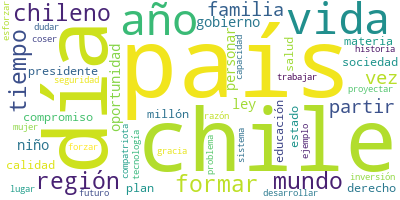

In [ ]:
# Import the wordcloud library
import pandas as pd
import re
from wordcloud import WordCloud

# Join the different processed titles together.
# Create a WordCloud object

texto = counter.most_common(50)
texto = pd.DataFrame(texto)
texto = texto.iloc[:,0]

texto = str(texto)

wordcloud = WordCloud(background_color="white", max_words=50, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(texto)
# Visualize the word cloud
wordcloud.to_image()

# Modelo LDA

Particionamos los datos en un conjunto de entrenamiento y de prueba.

In [ ]:
from sklearn.model_selection import train_test_split


processed_corpus_train, processed_corpus_test = train_test_split(
    texts, test_size=0.25)

print(f"Tamaño conjunto de entrenamiento {len(processed_corpus_train)}")
print(f"Tamaño conjunto de prueba {len(processed_corpus_test)}")

Tamaño conjunto de entrenamiento 510
Tamaño conjunto de prueba 170


Utilizamos **gensim.corpora** para modificar el CORPUS, de modo tal que podamos utilizarlo en el modelo LDA.

In [ ]:
from gensim.corpora import Dictionary


id2word = Dictionary(processed_corpus_train) # bolsa de palabras
corpus = [id2word.doc2bow(text) for text in processed_corpus_train]
corpus_test = [id2word.doc2bow(text) for text in processed_corpus_test]

Creamos el primer modelo con número de topicos definido aleatoriamente para tener un primer acercamiento de los datos.

In [ ]:
from gensim.models.ldamodel import LdaModel


lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=5,
                     random_state=100,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

## Visualización Tópicos

Visualizamos los tópicos con el modelo creado en el paso anterior.

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.105983  0.025742       1        1  38.993052
1     -0.032436 -0.121410       2        1  24.992140
3     -0.112177 -0.103712       3        1  23.033791
2     -0.084464  0.189853       4        1  11.478073
4      0.335059  0.009526       5        1   1.502944, topic_info=            Term         Freq        Total Category  logprob  loglift
51         chile  3371.000000  3371.000000  Default  30.0000  30.0000
244       región  1648.000000  1648.000000  Default  29.0000  29.0000
194  oportunidad  1113.000000  1113.000000  Default  28.0000  28.0000
188         niño  1197.000000  1197.000000  Default  27.0000  27.0000
351         país  3828.000000  3828.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
277        temer    22.617433   508.588351   Topic5  -4.9535   1.0848
246     relación    16.872778   103.726270   Topic5  -5.2465   2.3817
973       crisis    16.564651   138.012779   Topic5  -5.2649   2.0777
298         vida    19.972540  2348.126831   Topic5  -5.0778  -0.5693
673       frente    16.051260   312.499102   Topic5  -5.2964   1.2289

[371 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
412       1  0.991608     abuso
2249      4  0.974621  academia
375       1  0.357629   acuerdo
375       2  0.580830   acuerdo
375       4  0.060873   acuerdo
...     ...       ...       ...
311       2  0.392839     época
311       3  0.084180     época
311       4  0.074826     época
311       5  0.215126     época
5343      3  0.987351     ñuble

[653 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3, 5])

## Elección del modelo

Utilizaremos el puntaje de coherencia como métrica de calidad del modelo. 

Para efectos de este trabajo mantuvimos `random_state` con el fin de comparar resultados.

Definimos la función **compute_coherence_values** que nos permitirá conocer los valores de coherencia para un determinado numero de tópicos y así poder seleccionar el que a nuestro criterio podría mejorar la calidad del modelo.

In [ ]:
from gensim.models import CoherenceModel


def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(list(range(start, limit, step))):
        lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=num_topics,
                     random_state=100,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())
        #perp

    return model_list, coherence_values

Evaluamos tópicos desde dos hasta diez. 

In [ ]:
import warnings


warnings.filterwarnings("ignore",category=DeprecationWarning)

start = 2
limit = 10
step = 1
model_list, coherence_values = compute_coherence_values(id2word, corpus, texts, limit, start, step)

100%|██████████| 8/8 [01:27<00:00, 10.88s/it]


Graficamos los resultados de coherencia descritos en los puntos anteriores.

En el caso del gráfico, el mejor modelo sería con 9 tópicos


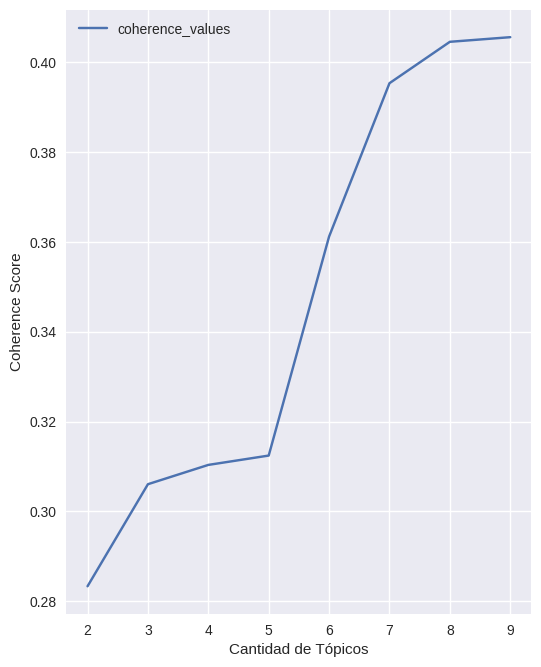

In [ ]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (6, 8)
plt.rcParams["figure.dpi"] = 100


x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Cantidad de Tópicos")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values",), loc="best")

print(f"En el caso del gráfico, el mejor modelo sería con {np.argmax(coherence_values)+2} tópicos")

Podemos observar que el valor de coherencia mas alto se encuentra con nueve tópicos.

In [ ]:
list(enumerate(zip(x, coherence_values)))

[(0, (2, 0.2833440224154675)),
 (1, (3, 0.30605356421602586)),
 (2, (4, 0.31034778935779833)),
 (3, (5, 0.31242658701916143)),
 (4, (6, 0.3611636250793128)),
 (5, (7, 0.39528070448530034)),
 (6, (8, 0.4044917558673654)),
 (7, (9, 0.4055217506613494))]

Observamos los valores y al utilizar el valor máximo de coherencia que se encuentra con nueve tópicos, estos quedan traslapados unos con otros lo que dificulta la posilidad de interpretarlos, en consecuencia definimos utilizar cinco tópicos ya que la distribución de ellos nos permite poder interpretarlos.  

In [ ]:
best_model = model_list[3]

In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.105983  0.025742       1        1  38.993052
1     -0.032436 -0.121410       2        1  24.992140
3     -0.112177 -0.103712       3        1  23.033791
2     -0.084464  0.189853       4        1  11.478073
4      0.335059  0.009526       5        1   1.502944, topic_info=            Term         Freq        Total Category  logprob  loglift
51         chile  3371.000000  3371.000000  Default  30.0000  30.0000
244       región  1648.000000  1648.000000  Default  29.0000  29.0000
194  oportunidad  1113.000000  1113.000000  Default  28.0000  28.0000
188         niño  1197.000000  1197.000000  Default  27.0000  27.0000
351         país  3828.000000  3828.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
277        temer    22.617433   508.588351   Topic5  -4.9535   1.0848
246     relación    16.872778   103.726270   Topic5  -5.2465   2.3817
973       crisis    16.564651   138.012779   Topic5  -5.2649   2.0777
298         vida    19.972540  2348.126831   Topic5  -5.0778  -0.5693
673       frente    16.051260   312.499102   Topic5  -5.2964   1.2289

[371 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
412       1  0.991608     abuso
2249      4  0.974621  academia
375       1  0.357629   acuerdo
375       2  0.580830   acuerdo
375       4  0.060873   acuerdo
...     ...       ...       ...
311       2  0.392839     época
311       3  0.084180     época
311       4  0.074826     época
311       5  0.215126     época
5343      3  0.987351     ñuble

[653 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3, 5])

## La interpretación que nosotros le damos a cada tópico es la siguiente:


*   Topico 1: Sociedad
*   Topico 2: Relaciones exteriores
*   Topico 3: Desarrollo regional
*   Topico 4: Fuerzas armadas
*   Topico 5: Contingencia



In [ ]:
topico1='sociedad'
topico2='relaciones_exteriores'
topico3='desarrollo_regional'
topico4='fuerzas_armadas'
topico5='contingencia'

## Predicción del modelo:

De acuerdo a los parametros definidos para entrenar el modelo, generamos las predicciones para los documentos de validación y sus respectivos tópicos. 

In [ ]:
most_probable_topic_test = []

for indexed_doc in best_model[corpus_test]:
    most_prob_topic, max_prob = indexed_doc[0][0]
    for topic, prob in indexed_doc[0]:
        if prob > max_prob:
            max_prob = prob
            most_prob_topic = topic
    most_probable_topic_test.append(most_prob_topic)

In [ ]:
doc=0
for i in most_probable_topic_test:
  doc = doc + 1 
  print(f"El documento de validación {doc}, pertenece al tópico {most_probable_topic_test[i]+1}")

El documento de validación 1, pertenece al tópico 1
El documento de validación 2, pertenece al tópico 1
El documento de validación 3, pertenece al tópico 1
El documento de validación 4, pertenece al tópico 1
El documento de validación 5, pertenece al tópico 4
El documento de validación 6, pertenece al tópico 3
El documento de validación 7, pertenece al tópico 3
El documento de validación 8, pertenece al tópico 1
El documento de validación 9, pertenece al tópico 1
El documento de validación 10, pertenece al tópico 1
El documento de validación 11, pertenece al tópico 1
El documento de validación 12, pertenece al tópico 1
El documento de validación 13, pertenece al tópico 1
El documento de validación 14, pertenece al tópico 4
El documento de validación 15, pertenece al tópico 4
El documento de validación 16, pertenece al tópico 1
El documento de validación 17, pertenece al tópico 3
El documento de validación 18, pertenece al tópico 4
El documento de validación 19, pertenece al tópico 1
El

In [ ]:
print('Tópico que le asigna el modelo:')
print(most_probable_topic_test[0] + 1)
print('Al siguiente documento:')
print(processed_corpus_test[0])

Tópico que le asigna el modelo:
1
Al siguiente documento:
['tarde', 'bienvenidos', 'casa', 'moneda', 'casar', 'chileno', 'día', 'momento', 'octubre', 'año', 'lugar', 'zanjón', 'aguada', 'grupo', 'personar', 'liderazgo', 'ministro', 'familia', 'desarrollo', 'social', 'desarrollo', 'social', 'familia', 'aventurar', 'palabra', 'proyectar', 'nombrar', 'significar', 'compromiso', 'país', 'partir', 'día', 'personar', 'día', 'personar', 'ideo', 'capacidad', 'organización', 'sociedad', 'ministerios', 'ministros', 'compromiso', 'voluntad', 'importancia', 'trascendencia', 'labor', 'reunión', 'decena', 'salir', 'terreno', 'grupo', 'suponer', 'compromiso', 'entregar', 'liderazgo', 'ministro', 'miembro', 'ministerio', 'desarrollo', 'social', 'familia', 'documentar', 'día', 'verdad', 'trabajar', 'grupo', 'dudar', 'futuro', 'documentar', 'carne', 'iniciativo', 'fruto', 'trabajar', 'grupo', 'compromiso', 'país', 'contribución', 'chile', 'vez', 'pilar', 'clave', 'país', 'empleo', 'educación', 'familia'

In [ ]:
query1 = input("Interpretación:")

Interpretación:sociedad


In [ ]:
print('Tópico que le asigna el modelo:')
print(most_probable_topic_test[1] + 1)
print('Al siguiente documento:')
print(processed_corpus_test[1])

Tópico que le asigna el modelo:
1
Al siguiente documento:
['queridas', 'chileno', 'noche', 'noche', 'compatriota', 'formar', 'padre', 'madre', 'profesor', 'niño', 'joven', 'presidente', 'chileno', 'padre', 'abuelo', 'condición', 'preocupación', 'incrementar', 'consumir', 'drogar', 'niño', 'niño', 'adolescente', 'iniciar', 'consumir', 'vez', 'edad', 'niño', 'adolescente', 'lugar', 'país', 'américa', 'consumir', 'marihuana', 'cocaína', 'pastar', 'basar', 'tranquilizante', 'recetar', 'consumir', 'adulto', 'dudar', 'epidemia', 'año', 'creencia', 'consumir', 'marihuana', 'drogar', 'salud', 'capacidad', 'intelectual', 'niño', 'adolescente', 'verdad', 'vez', 'sociedad', 'drogar', 'drogar', 'vida', 'familia', 'sueño', 'drogar', 'dolor', 'sufrimiento', 'adicto', 'familia', 'ser', 'drogar', 'libertar', 'voluntad', 'felicidad', 'capacidad', 'familia', 'ser', 'sociedad', 'término', 'capacidad', 'talento', 'realizarnos', 'personar', 'felicidad', 'síntesis', 'esclavo', 'razonar', 'relación', 'drogar

In [ ]:
query2 = input("Interpretación:")

Interpretación:drogadiccion


In [ ]:
print('Tópico que le asigna el modelo:')
print(most_probable_topic_test[100] + 1)
print('Al siguiente documento:')
print(processed_corpus_test[100])

Tópico que le asigna el modelo:
1
Al siguiente documento:
['día', 'día', 'recuerdo', 'reflexionar', 'año', 'golpe', 'militar', 'septiembre', 'año', 'muerte', 'presidente', 'allende', 'bombardear', 'moneda', 'término', 'gobierno', 'unidad', 'popular', 'año', 'iniciar', 'gobierno', 'militar', 'año', 'quebrar', 'democracia', 'dudar', 'septiembre', 'fecho', 'chileno', 'interpretación', 'día', 'división', 'odio', 'chile', 'tiempo', 'lección', 'enseñanza', 'período', 'historia', 'dudar', 'lección', 'enseñanza', 'lugar', 'importancia', 'democracia', 'convivencia', 'chileno', 'septiembre', 'democracia', 'muerte', 'enfermo', 'tiempo', 'vez', 'circunstancia', 'contexto', 'sistemático', 'atropello', 'derecho', 'humano', 'período', 'país', 'embargar', 'preguntar', 'lección', 'democracia', 'septiembre', 'mal', 'enfermedad', 'democracia', 'enfermo', 'odiar', 'violencia', 'descalificación', 'intolerancia', 'sectarismo', 'sector', 'violencia', 'instrumentar', 'luchar', 'conquistar', 'poder', 'democrac

In [ ]:
query3 = input("Interpretación:")

Interpretación:fuerzas_armadas


In [ ]:
print('Tópico que le asigna el modelo:')
print(most_probable_topic_test[160] + 1)
print('Al siguiente documento:')
print(processed_corpus_test[160])

Tópico que le asigna el modelo:
5
Al siguiente documento:
['momento', 'alegría', 'esperanzar', 'día', 'fin', 'región', 'ñuble', 'esperanzar', 'región', 'largar', 'cunar', 'hombre', 'mujer', 'región', 'país', 'hombre', 'arturo', 'prat', 'bernardo', 'higgins', 'artista', 'violeta', 'parra', 'nicanor', 'parra', 'claudio', 'arrau', 'ñuble', 'chile', 'largar', 'historia', 'región', 'forzar', 'destinar', 'mano', 'plan', 'desarrollo', 'región', 'ñuble', 'habitante', 'región', 'motor', 'agricultura', 'región', 'potenciar', 'tratados', 'comercio', 'patrimonio', 'clima', 'sol', 'aguar', 'región', 'potenciar', 'mesar', 'compatriota', 'mundo', 'región', 'potencial', 'materia', 'energía', 'suponer', 'región', 'región', 'cunar', 'tradición', 'historia', 'costumbre', 'leyenda', 'región', 'ñuble', 'país', 'habitante', 'región', 'fuerza', 'región', 'habitante', 'problema', 'potencialidad', 'temor', 'sueño', 'proyecto', 'inversión', 'región', 'ejemplo', 'embalsar', 'punilla', 'hectárea', 'elementar', 'h

In [ ]:
query4 = input("Interpretación:")

Interpretación:desarrollo_regional


In [ ]:
print('Tópico que le asigna el modelo:')
print(most_probable_topic_test[58] + 1)
print('Al siguiente documento:')
print(processed_corpus_test[58])

Tópico que le asigna el modelo:
3
Al siguiente documento:
['pedro', 'carcuro', 'pie', 'deportista', 'deportista', 'chile', 'país', 'deportista', 'misión', 'ministerio', 'deporte', 'millón', 'razonar', 'deportista', 'dirigente', 'deportar', 'cuerpo', 'salud', 'alma', 'partir', 'palabra', 'éxito', 'palabra', 'trabajar', 'diccionario', 'casualidad', 'talento', 'talento', 'compromiso', 'esforzar', 'sacrificio', 'talento', 'deportar', 'elite', 'país', 'juegos', 'suramericanos', 'cochabamba', 'partir', 'ciclar', 'juegos', 'panamericanos', 'lima', 'juegos', 'olímpicos', 'tokio', 'año', 'juegos', 'panamericanos', 'chile', 'delegación', 'chile', 'evento', 'preguntar', 'ministro', 'pillarla', 'mujer', 'hombre', 'uy', 'pillar', 'intención', 'mujer', 'hombre', 'orgullo', 'esperanzar', 'ilusionar', 'país', 'deportista', 'medalla', 'frente', 'alto', 'chile', 'gobierno', 'chile', 'compromiso', 'deportar', 'deportar', 'deportar', 'rincón', 'país', 'niño', 'mujer', 'hombre', 'trabajador', 'edad', 'regi

In [ ]:
query5 = input("Interpretación:")

Interpretación:deporte


In [ ]:
print('Tópico que le asigna el modelo:')
print(most_probable_topic_test[12] + 1)
print('Al siguiente documento:')
print(processed_corpus_test[12])

Tópico que le asigna el modelo:
1
Al siguiente documento:
['día', 'lugar', 'gracia', 'dios', 'mañana', 'sol', 'invierno', 'ministra', 'alcalde', 'diputar', 'melero', 'desbordes', 'pardo', 'suponer', 'cariño', 'maría', 'angélica', 'vallejos', 'biblia', 'fruto', 'conocer', 'liceos', 'bicentenario', 'año', 'fruto', 'ideo', 'concepto', 'liceo', 'bicentenario', 'educación', 'educación', 'tiempo', 'año', 'coser', 'admisión', 'colegio', 'colegio', 'calidad', 'educación', 'debatir', 'prioridad', 'ministra', 'cubillos', 'calidad', 'educación', 'corazón', 'debatir', 'calidad', 'educación', 'nivelar', 'educación', 'educación', 'educación', 'calidad', 'educación', 'objetivar', 'educación', 'instrumentar', 'educación', 'alumno', 'liceo', 'día', 'puerta', 'mundo', 'oportunidad', 'educación', 'vez', 'mundo', 'frustración', 'calidad', 'educación', 'corazón', 'centrar', 'debatir', 'ministra', 'marcela', 'cubillos', 'calidad', 'educación', 'liceos', 'bicentenario', 'aportar', 'compromiso', 'voluntad', '

In [ ]:
query6 = input("Interpretación:")

Interpretación:educacion


In [ ]:
print('Tópico que le asigna el modelo:')
print(most_probable_topic_test[44] + 1)
print('Al siguiente documento:')
print(processed_corpus_test[44])

Tópico que le asigna el modelo:
3
Al siguiente documento:
['día', 'verdad', 'orgullo', 'emoción', 'alegría', 'mujer', 'cecilia', 'españa', 'soltero', 'oportunidad', 'partir', 'disfrutarlos', 'hora', 'noche', 'casar', 'partir', 'partir', 'selección', 'partir', 'dudar', 'partir', 'frente', 'uruguay', 'uruguayo', 'meterles', 'gol', 'tiempo', 'compatriota', 'alegría', 'emoción', 'muchacho', 'año', 'cúspide', 'carrera', 'mundial', 'fútbol', 'chile', 'tocayo', 'sebastián', 'oportunidad', 'equipar', 'subcampeón', 'verdad', 'partir', 'dudar', 'partir', 'argentina', 'ecuador', 'chile', 'campeón', 'gol', 'gol', 'paraguay', 'gol', 'ecuatoriano', 'argentino', 'casar', 'tiempo', 'selección', 'sub', 'subcampeón', 'américa', 'año', 'década', 'desafiar', 'brasil', 'lugar', 'japón', 'meter', 'esperanzar', 'mesar', 'hernán', 'caputto', 'líder', 'estratega', 'entretiempo', 'uruguay', 'inspiración', 'transpiración', 'vida', 'inspiración', 'transpiración', 'talento', 'creatividad', 'abundancia', 'trabajar'

In [ ]:
query7 = input("Interpretación:")

Interpretación:futbol


In [ ]:
print('Tópico que le asigna el modelo:')
print(most_probable_topic_test[66] + 1)
print('Al siguiente documento:')
print(processed_corpus_test[66])

Tópico que le asigna el modelo:
3
Al siguiente documento:
['gracia', 'verdad', 'reunión', 'cop', 'santiago', 'oportunidad', 'cursar', 'mundo', 'respectar', 'generación', 'desafío', 'generación', 'desafiar', 'respectar', 'cambiar', 'calentamiento', 'verdad', 'batallar', 'vida', 'ser', 'criatura', 'planeta', 'tiempo', 'vez', 'planeta', 'suponer', 'tiempo', 'liderazgo', 'coser', 'ciudadano', 'país', 'mundo', 'misión', 'tiempo', 'dificultad', 'día', 'dificultad', 'problema', 'economía', 'guerra', 'potenciar', 'problema', 'cambiar', 'vez', 'crisis', 'dificultad', 'complejo', 'desafío', 'liderazgo', 'interesar', 'competencia', 'grupo', 'casar', 'interesar', 'ecuación', 'supervivencia', 'vez', 'revistar', 'fotografiar', 'planeta', 'tierra', 'titular', 'salvemos', 'planeta', 'tierra', 'planeta', 'tierra', 'riesgo', 'planeta', 'tierra', 'millón', 'año', 'tipo', 'catástrofe', 'realidad', 'riesgo', 'sobrevivencia', 'raza', 'planeta', 'resultar', 'informar', 'situación', 'vez', 'ejemplo', 'informa

In [ ]:
query8 = input("Interpretación:")

Interpretación:relaciones_exteriores


In [ ]:
print('Tópico que le asigna el modelo:')
print(most_probable_topic_test[70] + 1)
print('Al siguiente documento:')
print(processed_corpus_test[70])

Tópico que le asigna el modelo:
1
Al siguiente documento:
['día', 'bienvenido', 'pablo', 'félix', 'familia', 'organización', 'chileno', 'chileno', 'tiempo', 'proyectar', 'ley', 'identidad', 'género', 'principio', 'valorar', 'presidente', 'gobierno', 'personar', 'personar', 'dignidad', 'derecho', 'deber', 'consecuencia', 'personar', 'libertar', 'creatividad', 'motor', 'sociedad', 'arquitecto', 'vida', 'concepto', 'libertar', 'dignidad', 'ser', 'ley', 'identidad', 'género', 'pasar', 'dirección', 'deuda', 'sociedad', 'prejuicio', 'discriminación', 'compromiso', 'dignidad', 'obligación', 'tiempo', 'discusión', 'año', 'congreso', 'partir', 'ley', 'institucionalidad', 'lugar', 'edad', 'autonomía', 'voluntad', 'cambiar', 'sexo', 'acordar', 'voluntad', 'acordar', 'libertar', 'personar', 'año', 'ley', 'consentimiento', 'padre', 'juez', 'familia', 'lugar', 'edad', 'año', 'cambiar', 'sexo', 'condición', 'trans', 'estado', 'instancia', 'escuela', 'acceso', 'salud', 'acompañamiento', 'estado', 'pad

In [ ]:
query9 = input("Interpretación:")

Interpretación:sociedad


In [ ]:
print('Tópico que le asigna el modelo:')
print(most_probable_topic_test[87] + 1)
print('Al siguiente documento:')
print(processed_corpus_test[87])

Tópico que le asigna el modelo:
1
Al siguiente documento:
['día', 'futuro', 'entusiasmar', 'esperanzar', 'hoy', 'día', 'pasar', 'avanzar', 'tecnología', 'revolución', 'sociedad', 'conocimiento', 'información', 'consentimiento', 'voluntad', 'preguntar', 'respuesta', 'revolución', 'sociedad', 'conocimiento', 'información', 'ola', 'opción', 'subirnos', 'surfearla', 'fuerza', 'beneficiar', 'espalda', 'consecuencia', 'sociedad', 'conocimiento', 'información', 'mundo', 'país', 'asumir', 'favor', 'país', 'espalda', 'prepararnos', 'ola', 'medir', 'materia', 'ciberseguridad', 'ola', 'poder', 'surfearla', 'beneficiar', 'reformar', 'partir', 'revolución', 'tiempo', 'puerta', 'razón', 'día', 'presidencial', 'ciberseguridad', 'proyectar', 'ley', 'delitos', 'informáticos', 'partir', 'política', 'nacional', 'ciberseguridad', 'proyectar', 'protección', 'datos', 'personales', 'congreso', 'urgencia', 'coordinación', 'infraestructura', 'capacidad', 'defensa', 'frente', 'amenazar', 'revolución', 'país', '

In [ ]:
query10 = input("Interpretación:")

Interpretación:tecnologia


In [ ]:
print('Tópico que le asigna el modelo:')
print(most_probable_topic_test[88] + 1)
print('Al siguiente documento:')
print(processed_corpus_test[88])

Tópico que le asigna el modelo:
3
Al siguiente documento:
['bienvenido', 'secretario', 'defensa', 'estados', 'unidos', 'delegación', 'oportunidad', 'temer', 'agenda', 'estados', 'unidos', 'chile', 'temer', 'temer', 'continente', 'temer', 'naturaleza', 'intención', 'país', 'relación', 'estados', 'unidos', 'amigo', 'causar', 'valorar', 'principio', 'compromiso', 'democracia', 'respetar', 'derecho', 'humano', 'estado', 'derecho', 'paz', 'punto', 'vestir', 'dudar', 'relación', 'estados', 'unidos', 'desafío', 'misionar', 'secretario', 'defensa', 'delegación', 'delegación', 'temer', 'ejemplo', 'colaboración', 'materia', 'tiempo', 'guerra', 'tiempo', 'paz', 'fuerzas', 'armadas', 'rol', 'soberanía', 'integridad', 'rol', 'ciudadano', 'tiempo', 'desastre', 'catástrofe', 'país', 'colaboración', 'estados', 'unidos', 'chile', 'área', 'país', 'centroamérica', 'caribe', 'reunión', 'presidentes', 'país', 'zona', 'temporada', 'huracán', 'chile', 'estados', 'unidos', 'país', 'adversidad', 'desastre', 't

In [ ]:
query11 = input("Interpretación:")

Interpretación:contingencia


In [ ]:
print('Tópico que le asigna el modelo:')
print(most_probable_topic_test[93] + 1)
print('Al siguiente documento:')
print(processed_corpus_test[93])

Tópico que le asigna el modelo:
3
Al siguiente documento:
['tarde', 'honor', 'visitar', 'asunción', 'gobierno', 'momento', 'satisfacción', 'presidenta', 'república', 'croacia', 'kolinda', 'grabar', 'kitarovic', 'secretaria', 'estado', 'delegación', 'croacia', 'presidenta', 'apreciar', 'país', 'embajador', 'croacia', 'oportunidad', 'profundidad', 'país', 'acuerdo', 'agenda', 'colaboración', 'campar', 'período', 'fuente', 'colaboración', 'oportunidad', 'presidenta', 'campo', 'croacia', 'valorar', 'compromiso', 'democracia', 'libertar', 'estado', 'derecho', 'respetar', 'derecho', 'humano', 'visión', 'integración', 'mundo', 'dudar', 'colaboración', 'república', 'croacia', 'república', 'chile', 'relacionar', 'tiempo', 'chile', 'país', 'américa', 'latina', 'cuartar', 'naciente', 'república', 'croacia', 'diputar', 'don', 'baldo', 'prokurica', 'rol', 'campar', 'relacionar', 'año', 'verdad', 'amistar', 'cercanía', 'siglo', 'visitar', 'visitar', 'coser', 'común', 'chile', 'presidenta', 'colabora

In [ ]:
query12 = input("Interpretación:")

Interpretación:relaciones_exteriores


In [ ]:
print('Tópico que le asigna el modelo:')
print(most_probable_topic_test[95] + 1)
print('Al siguiente documento:')
print(processed_corpus_test[95])

Tópico que le asigna el modelo:
1
Al siguiente documento:
['tarde', 'preocupación', 'chileno', 'seguridad', 'orden', 'consecuencia', 'prioridad', 'compromiso', 'gobierno', 'delincuencia', 'narcotráfico', 'crimen', 'terrorismo', 'forzar', 'ley', 'policía', 'razón', 'frente', 'enemigo', 'profesional', 'centímetro', 'ventaja', 'actitud', 'chileno', 'carabinero', 'policía', 'investigaciones', 'necesidad', 'combatirlos', 'rigor', 'forzar', 'eficacia', 'partir', 'motivación', 'proyectar', 'modernización', 'carabineros', 'congreso', 'proyectar', 'ley', 'comisión', 'seguridad', 'senado', 'día', 'senador', 'comisión', 'seguridad', 'trámite', 'ley', 'instrumento', 'capacidad', 'carabineros', 'policía', 'investigaciones', 'sistema', 'inteligencia', 'partir', 'transparencia', 'probidad', 'usar', 'recurso', 'partir', 'darle', 'eficacia', 'potenciar', 'capacidad', 'delincuencia', 'crimen', 'terrorismo', 'proyecto', 'ley', 'inteligencia', 'enemigo', 'sociedad', 'ley', 'control', 'armar', 'rol', 'muni

In [ ]:
query13 = input("Interpretación:")

Interpretación:fuerzas_armadas


In [ ]:
print('Tópico que le asigna el modelo:')
print(most_probable_topic_test[81] + 1)
print('Al siguiente documento:')
print(processed_corpus_test[81])

Tópico que le asigna el modelo:
1
Al siguiente documento:
['tarde', 'lugar', 'gratitud', 'alma', 'corazón', 'cabeza', 'proyectar', 'compromiso', 'país', 'saludo', 'comunidad', 'empresario', 'miembro', 'organización', 'suponer', 'ministro', 'proyectar', 'ministro', 'alfredo', 'moreno', 'responsabilidad', 'iniciativo', 'palabra', 'misión', 'chile', 'país', 'pobreza', 'igualdad', 'oportunidad', 'movilidad', 'desigualdad', 'coser', 'pasar', 'década', 'ingresar', 'cápita', 'usd', 'usd', 'paridad', 'nivelar', 'día', 'país', 'españa', 'italia', 'nueva', 'zelandia', 'ejemplo', 'crecimiento', 'instrumentar', 'fin', 'fin', 'desarrollar', 'desarrollar', 'pan', 'hombre', 'democracia', 'institución', 'convivencia', 'seguridad', 'hogar', 'familia', 'medioambiente', 'naturaleza', 'tren', 'suponer', 'tren', 'locomotora', 'combustible', 'tren', 'avanzar', 'chileno', 'chileno', 'tren', 'desarrollar', 'ejemplo', 'grupo', 'millón', 'chileno', 'chileno', 'educación', 'educación', 'sociedad', 'conocimiento'

In [ ]:
query14 = input("Interpretación:")

Interpretación:sociedad


In [ ]:
print('Tópico que le asigna el modelo:')
print(most_probable_topic_test[62] + 1)
print('Al siguiente documento:')
print(processed_corpus_test[62])

Tópico que le asigna el modelo:
1
Al siguiente documento:
['día', 'señor', 'ministro', 'señor', 'subsecretario', 'parlamentarios', 'dirigentes', 'dirigirme', 'trabajador', 'país', 'gobierno', 'año', 'gobernar', 'balance', 'tiempo', 'compromiso', 'tiempo', 'cuenta', 'palabra', 'objetivo', 'compatriota', 'cargar', 'urgencia', 'decisión', 'coraje', 'orden', 'casar', 'materia', 'migración', 'pie', 'igualdad', 'derecho', 'obligación', 'dignidad', 'hombre', 'mujer', 'tolerancia', 'cero', 'tipo', 'violencia', 'maltratar', 'abusar', 'mujer', 'niño', 'fila', 'carabineros', 'chile', 'eficacia', 'delincuencia', 'urgencia', 'urgencia', 'chile', 'marchar', 'país', 'dinamismo', 'liderazgo', 'crecimiento', 'creación', 'empleo', 'inversión', 'productividad', 'innovación', 'emprendimiento', 'año', 'año', 'chile', 'chile', 'marchar', 'tasar', 'crecimiento', 'empleo', 'calidad', 'salario', 'inversión', 'productividad', 'gobierno', 'día', 'forzar', 'prioridad', 'compatriota', 'modernización', 'modernizaci

In [ ]:
query15 = input("Interpretación:")

Interpretación:sociedad


Realizada la interpretación manual de 15 documentos aleatorios podemos concluir lo siguiente:

Interpretaciones:

4 similitudes entre el modelo y la interpretación manual.
11 diferencias entre el modelo y la interpretación manual.

En resumen, un 27% de las interpretaciones manuales coincidieron con la predicción del modelo.








## Conclusión:

El pre-procesamiento y limpieza que se realiza a los documentos es preponderante para los resultados del modelo, ya que, en las pruebas que realizamos inicialmente no incluimos expresiones regulares, ni realizamos etiquetado de palabras y lograr interpretar un tópico del resultado del modelo fue complejo.

Los topicos tienden a estar juntos dado que las temáticas o contexto de los discursos en general estan relacionados.

El máximo valor de coherencia no necesariamente es la mejor elección de la cantidad de tópicos, ya que, en nuestro modelo al utilizar el valor máximo de coherencia los tópicos quedaban traslapados unos con otros.

Finalmente consideramos que la interpretación del tópico es un tanto subjetiva y depende netamente de la persona que lo realiza.
